In [21]:
import pandas as pd

# Load forecast data
garch = pd.read_csv('../../results/models/GARCH_predictions.csv')
garch_lstm = pd.read_csv('../../results/models/garch-lstm_forecast.csv')
lstm = pd.read_csv('../../results/models/lstm_forecast.csv')
har = pd.read_csv('../../results/models/har_forecast.csv')
rf = pd.read_csv('../../results/models/rf_forecast.csv')
test = pd.read_csv('../../data/ethusd_lasso_selected.csv')[['time', 'RV_d,t']]

# Rename columns for clarity
garch.columns = ['time', 'GARCH']
garch_lstm.columns = ['time', 'GARCH_LSTM']
lstm.columns = ['time', 'LSTM']
har.columns = ['time', 'HAR']
rf.columns = ['time', 'RF']
test.columns = ['time', 'Actual_RV']

# Merge all data on 'time'
data = pd.merge(test, garch, on='time', how='inner')
data = pd.merge(data, garch_lstm, on='time', how='inner')
data = pd.merge(data, lstm, on='time', how='inner')
data = pd.merge(data, har, on='time', how='inner')
data = pd.merge(data, rf, on='time', how='inner')

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)


In [23]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

def evaluate_model(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return rmse, mape, r2


# Initialize an empty DataFrame with the desired columns
metrics = pd.DataFrame(columns=['Model', 'RMSE', 'MAPE', 'R2'])

# Evaluate each model
models = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR', 'RF']
for model in models:
    rmse, mape, r2 = evaluate_model(data['Actual_RV'], data[model])
    # Create a DataFrame for the new row
    new_row = pd.DataFrame({'Model': [model], 'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2]})
    # Concatenate the new row to the metrics DataFrame
    metrics = pd.concat([metrics, new_row], ignore_index=True)

print(metrics)


        Model      RMSE      MAPE        R2
0       GARCH  0.001342  1.815775  0.260041
1  GARCH_LSTM  0.001262  1.850859  0.345441
2        LSTM  0.001248  1.749720  0.359767
3         HAR  0.001189  1.257529  0.418689
4          RF  0.000666  0.247313  0.817417


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_97373/3800133429.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, new_row], ignore_index=True)


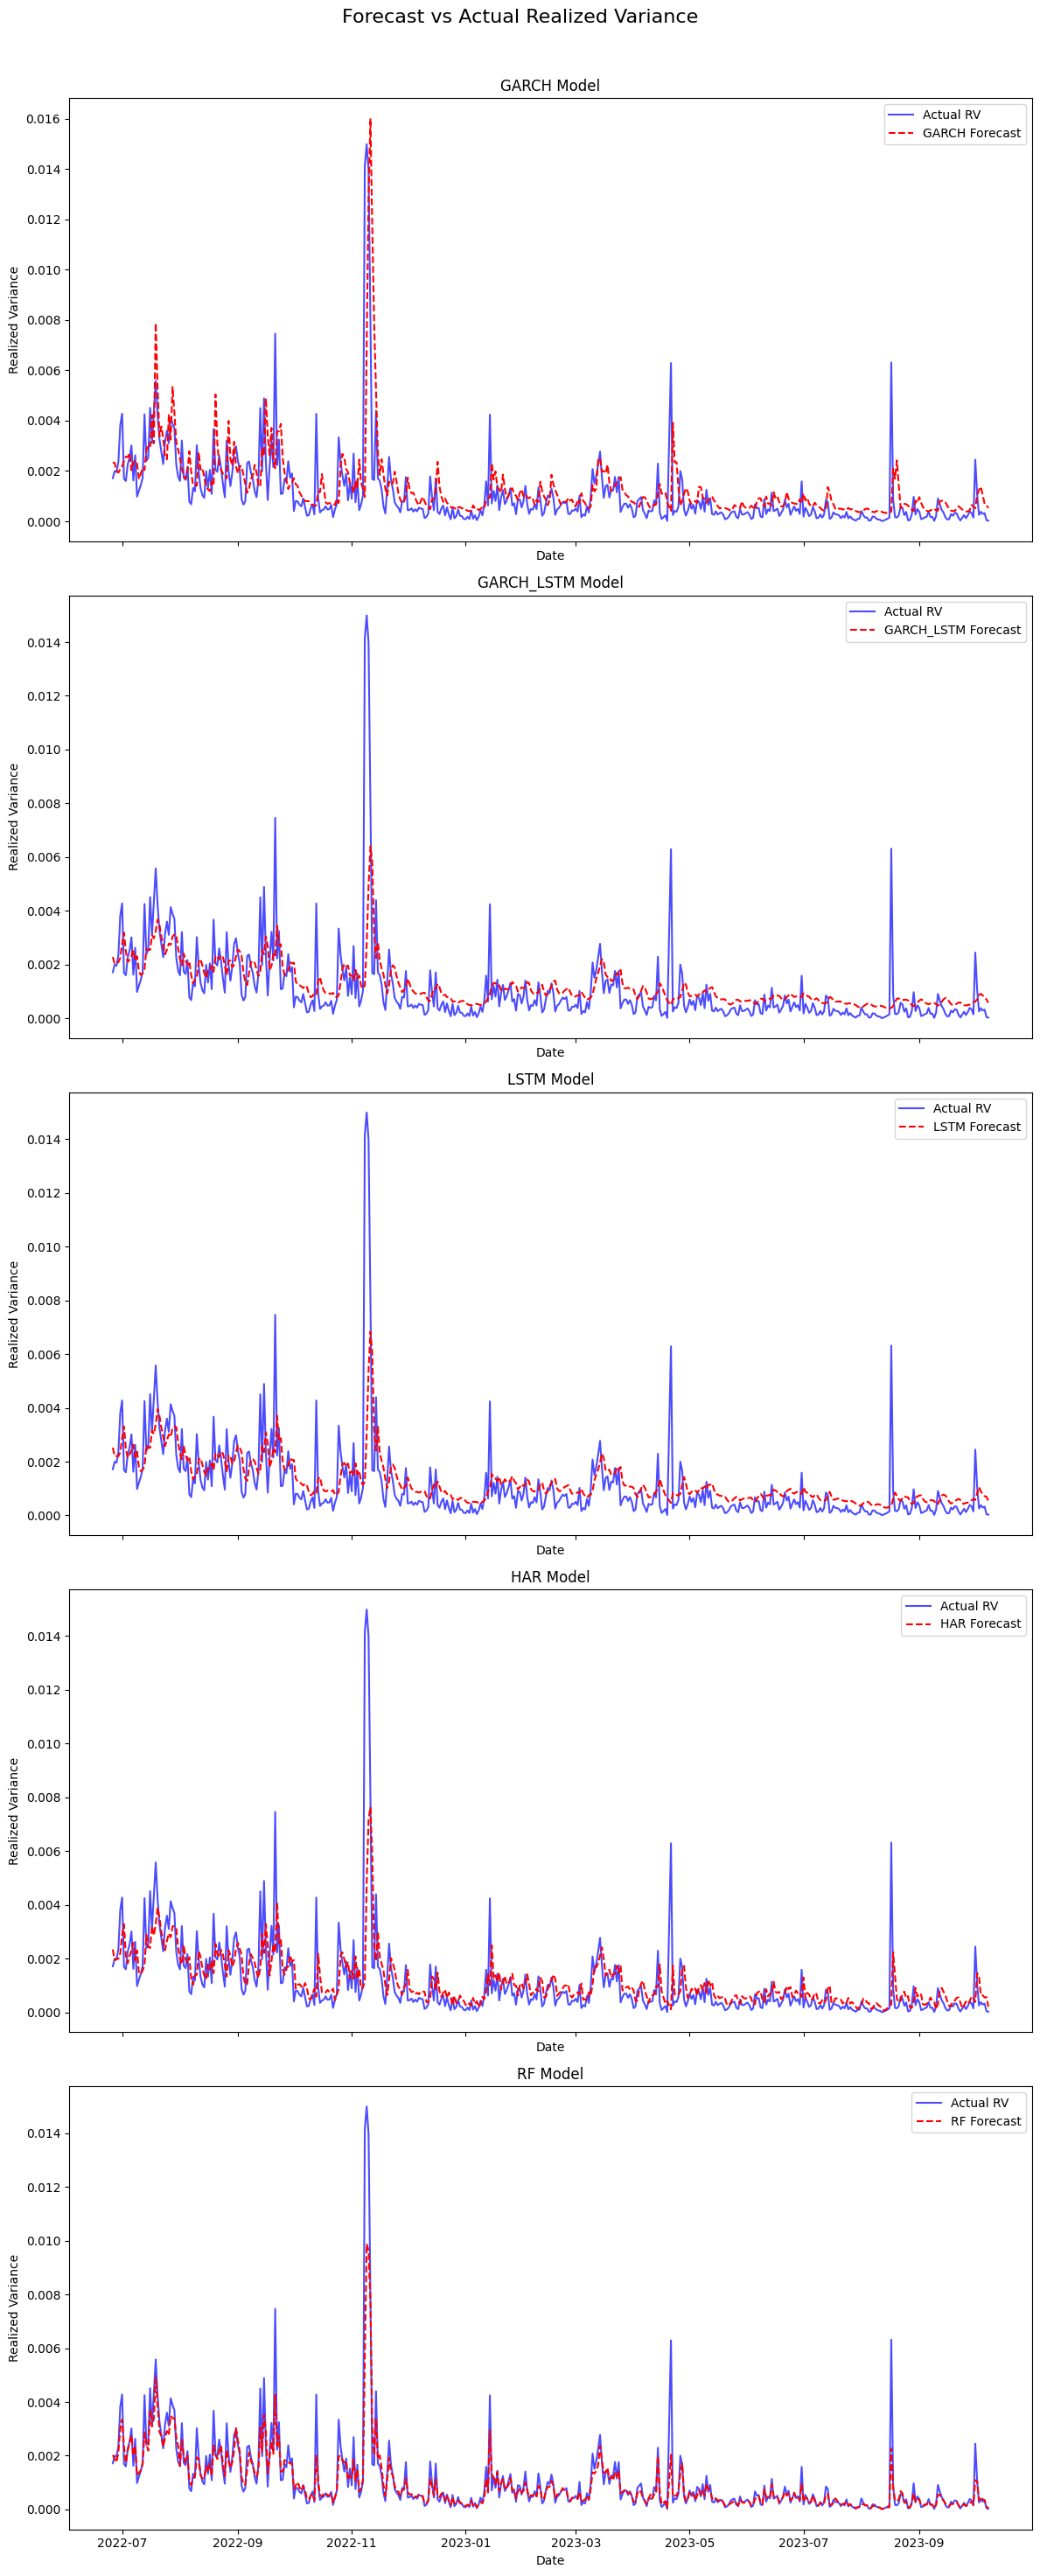

In [24]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 30), sharex=True)
fig.suptitle('Forecast vs Actual Realized Variance', fontsize=16)

# Plot each model's predictions
for ax, model in zip(axes, models):
    ax.plot(data.index, data['Actual_RV'], label='Actual RV', color='blue', alpha=0.7)
    ax.plot(data.index, data[model], label=f'{model} Forecast', color='red', linestyle='dashed')
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Variance')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('../../results/figures/forecast_comparison_panel.png')
plt.show()
